# 1. Setting up!

### 1.1 Install  and Import Dependencies

In [1]:
# !pip install tensorflow==2.4.2 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
# !pip install tensorflow

In [3]:
# Importing standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
 # Import Tensorflow Deoendencies
 import tensorflow as tf
 from tensorflow.keras.models import Model
 from tensorflow.keras.layers import Conv2D, Layer, Dense, MaxPooling2D, Input, Flatten

In [5]:
pip show tensorflow

Name: tensorflowNote: you may need to restart the kernel to use updated packages.

Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\Utkarsh Sharma\AppData\Roaming\Python\Python311\site-packages
Requires: tensorflow-intel
Required-by: 


In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### 1.2 Set GPU Growth

In [8]:
# Avoid Out Of Memory errors by setting up GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### 1.3 Create Folder Structures

In [9]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive') # Truly identify
NEG_PATH = os.path.join('data', 'negative') # False identify
ANC_PATH = os.path.join('data', 'anchor') # jiske against verification hoga

In [10]:
POS_PATH

'data\\positive'

In [11]:
# Make those directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collecting Data

### 2.1 Collecting images from https://vis-www.cs.umass.edu/Lfw/#download and moving to negative folder

In [12]:
# Uncompress the folder of wild files
# !tar -xf lfw.tar

In [13]:
# Getting all the images in the "data/negative" folder
# for directory in os.listdir('lfw'):
#   for file in os.listdir(os.path.join('lfw', directory)):
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

### 2.2 Collecting positive and anchor images using Open CV

In [14]:
# Import uuid library to uniquely name our anchor and positive images
import uuid # Universal unieue identifier

In [15]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ab8e19a1-50cb-11ee-bba5-3024a9ef12e7.jpg'

In [16]:
# Establishing a connection to a webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
  # Taking a frame
  ret, frame = cap.read()
    
  # Resizing the frame
  frame = frame[120:120+250, 200:200+250, :]
    
  # Collecting anchor images
  if cv2.waitKey(1) & 0XFF == ord('a'):
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) # Create the unique path
    cv2.imwrite(imgname, frame) # Write the anchor image
    
  # Collecting positive images
  if cv2.waitKey(1) & 0XFF == ord('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())) # Create the unique path
    cv2.imwrite(imgname, frame) # Write the positive image

  # Show the taken frame on screen
  cv2.imshow('Image Collection', frame)

  # Getting out of webcam / Closing the webcam on pressing 'q' on keyboard
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()

### 2.2 Data Augmentation

In [17]:
# Define function to augment images to add more positive and anchor images with some more flavours to get better accuracy
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [18]:
# # Adding positive augmented images
# for file_name in os.listdir(os.path.join(POS_PATH)):
#     img_path = os.path.join(POS_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [19]:
# # Adding anchor augmented images
# for file_name in os.listdir(os.path.join(ANC_PATH)):
#     img_path = os.path.join(ANC_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and PreProcess Images

### 3.1 Get Image Directories

In [20]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [21]:
dir_test = anchor.as_numpy_iterator()

In [22]:
dir_test.next()

b'data\\anchor\\96cee7d5-508b-11ee-a5d3-3024a9ef12e7.jpg'

### 3.2 PreProcessing the images

In [23]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) # Reading the image
    img = tf.io.decode_jpeg(byte_img) # Decoding the image
    img = tf.image.resize(img, (100, 100)) # Resizing the image
    img = img/255.0 # Scaling the image to be between 0 and 1
    return img

In [24]:
img = preprocess('data\\anchor\\a9b45f17-474f-11ee-972a-3024a9ef12e7.jpg')

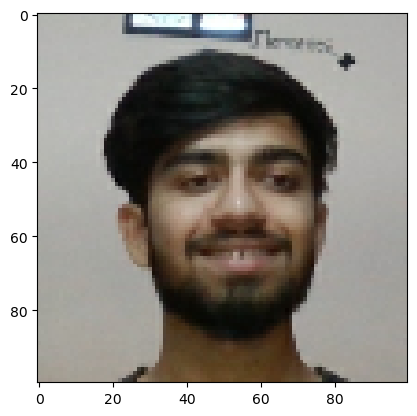

In [25]:
# img # To get numpy equivalent of the image
plt.imshow(img)

In [26]:
img.numpy().max() # As it is scaled

1.0

### 3.3 Create Labelled Dataset

In [27]:
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data = positives.concatenate(negatives)

In [28]:
type(data)

tensorflow.python.data.ops.concatenate_op._ConcatenateDataset

In [29]:
samples = data.as_numpy_iterator()

In [30]:
example = samples.next()

In [31]:
example

(b'data\\anchor\\7ea74b17-508b-11ee-84a3-3024a9ef12e7.jpg',
 b'data\\positive\\37099948-508b-11ee-bdd7-3024a9ef12e7.jpg',
 1.0)

### 3.4 Build Train and Test Split

In [32]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [33]:
res = preprocess_twin(*example)

In [34]:
len(res)

3

In [35]:
res[0] # preprocessed_image
res[1] # Sample image

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7257353 , 0.74534315, 0.71789217],
        [0.7343137 , 0.75784314, 0.71862745],
        [0.7262255 , 0.7497549 , 0.7105392 ],
        ...,
        [0.6931372 , 0.7323529 , 0.6970588 ],
        [0.68602943, 0.7252451 , 0.689951  ],
        [0.69411767, 0.73333335, 0.69803923]],

       [[0.7343137 , 0.75392157, 0.7264706 ],
        [0.7384804 , 0.7620098 , 0.7227941 ],
        [0.73112744, 0.75465685, 0.71544117],
        ...,
        [0.6931372 , 0.7323529 , 0.69509804],
        [0.6894608 , 0.7286765 , 0.69142157],
        [0.69215685, 0.73137254, 0.69411767]],

       [[0.7441176 , 0.7637255 , 0.7362745 ],
        [0.7355392 , 0.7590686 , 0.7198529 ],
        [0.7377451 , 0.7612745 , 0.72205883],
        ...,
        [0.6968137 , 0.73014706, 0.6870098 ],
        [0.6997549 , 0.73308825, 0.689951  ],
        [0.7019608 , 0.7352941 , 0.69215685]],

       ...,

       [[0.6431373 , 0.65882355, 0.6039216 ],
        [0.64

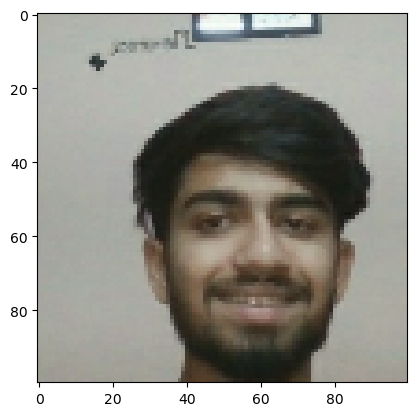

In [36]:
plt.imshow(res[0])

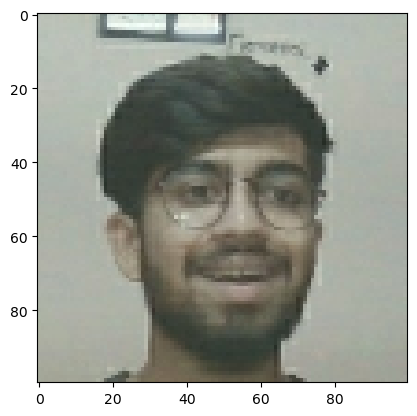

In [37]:
plt.imshow(res[1])

In [38]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache() # release cache along
data = data.shuffle(buffer_size=10000)

In [39]:
type(data)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [40]:
samples = data.as_numpy_iterator()

In [41]:
samp = samples.next()

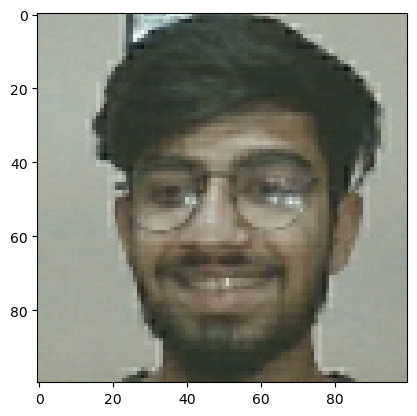

In [42]:
plt.imshow(samp[0])

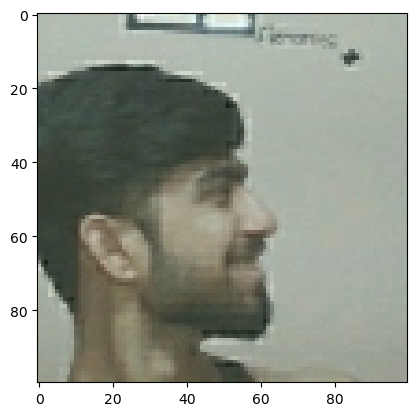

In [43]:
plt.imshow(samp[1])

In [44]:
samp[2]

1.0

In [45]:
# Training partition
train_data = data.take(round(len(data)*.7)) # Taking 70% of the data as training data 
train_data = train_data.batch(16) # Converting data into bacthes to make it able to prefetch
train_data = train_data.prefetch(8) # Converting to prefetch dataset

In [46]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [47]:
train_samples = train_data.as_numpy_iterator()

In [48]:
train_sample = train_samples.next()

In [49]:
len(train_sample[0]) # batch size of 16

16

In [50]:
# Testing Partitions
test_data = data.skip(round(len(data)*.7)) # Skipping 70% of the data as it is training data 
test_data = test_data.take(round(len(data)*.3)) # Taking rest 30% of the data as testing images
test_data = test_data.batch(16) # Converting data into bacthes to make it able to prefetch
test_data = test_data.prefetch(8) # Converting to prefetch dataset

In [51]:
test_samples = test_data.as_numpy_iterator()

In [52]:
test_sample = test_samples.next()

In [53]:
len(test_sample[0]) # batch size of 16

16

# 4. Model Engineering

### 4.1 Build Embedding Layer

In [54]:
inp = Input(shape = (100, 100, 3), name = 'input_image')

In [55]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [56]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)

In [57]:
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

In [58]:
c2 = Conv2D(128, (7, 7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

In [59]:
# Third Block
c3 = Conv2D(128, (4, 4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

# Final Embedding Block
c4 = Conv2D(256, (4, 4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [60]:
mod = Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [61]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [62]:
def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input_image')
    
    # First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final Embedding Block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4) # Flatening three dimensional data to single dimension
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [63]:
embedding = make_embedding()

In [64]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

### 4.2 Build Distance Layer

In [65]:
# Siamese Distance layer
class L1Dist(Layer):
    # Inheritance happens here
    def __init__(self, **kwargs): # kwargs -  keywords and arguments identifiable
        super().__init__()
        
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.abs(input_embedding - validation_embedding)

In [66]:
l1 = L1Dist()

In [67]:
# l1(anchor_embedding, validation_embedding)

### 4.3 Make Siamese Model

In [68]:
input_image = Input(name='input_img', shape=(100, 100, 3))

In [69]:
inp_embedding  = embedding(input_image)

In [70]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [71]:
validation_image = Input(name='validation_img', shape=(100, 100, 3))


In [72]:
val_embedding = embedding(validation_image)

In [73]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [74]:
siamese_layer = L1Dist()

In [75]:
distances = siamese_layer(inp_embedding, val_embedding)

In [76]:
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [77]:
# Classification Layer
classifier = Dense(1, activation='sigmoid')(distances)

In [78]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [79]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [80]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [81]:
def make_siamese_model():
    # Handle inputs
    
    # Anchor image inputs in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image inputs in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine Siamese Distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [82]:
siamese_model = make_siamese_model()

In [83]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

### 5.1 Setup Loss and Optimizer

In [84]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [85]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001 1e-7

### 5.2 Establish Checkpoints

In [86]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Build Train Step Function

In [87]:
test_batch = train_data.as_numpy_iterator()

In [88]:
batch_1 = test_batch.next()

In [89]:
x = batch_1[:2]

In [90]:
len(x[1])

16

In [91]:
y = batch_1[2]

In [92]:
y

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [93]:
# If you describe a function outside of a compiled model you need to do this in this way using tf decorator (@tf.function)
@tf.function
def train_step(batch):
    
    # To capture each function at each step inside of our neural network
    with tf.GradientTape() as tape:   
        
        # Get anchor and positive/negative image
        X = batch[:2]
        
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients for every epoch on the training (trainable variables)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to the siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

### 5.4 Build Training Loops

In [94]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [98]:
def train(data, EPOCHS):
    
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 5 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.4 Train the Model

In [99]:
EPOCHS = 20

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/20
151/263 [================>.............] - ETA: 1:25:40

# 6. Evaluating Model

### 6.1 Import Metrics

In [ ]:
# Import metrics 
from tensorflow.keras.metrics import Precision, Recall

### 6.2 Get a batch of data

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
test_var = test_data.as_numpy_iterator().next()

In [ ]:
len(test_var[0])

In [ ]:
# test_var[0]

In [ ]:
# test_val[0]

In [ ]:
test_var[2]

### 6.3 Make Predictions

In [ ]:
# Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

In [ ]:
# Processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

In [ ]:
y_true

### 6.4 Calculate Metrics

In [ ]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return recall
m.result().numpy()

In [ ]:
# Creating a metric object
m = Precision()

# Calculating the Precision value
m.update_state(y_true, y_hat)

# Return Precision
m.result().numpy()

### 6.5 Visualisation

In [ ]:
# Set the plot
plt.figure(figsize = (20, 10))

# plot first image
plt.subplot(1, 2, 1)
plt.imshow(test_input[5])

# PLot second image
plt.subplot(1, 2, 2)
plt.imshow(test_val[5])
plt.show()

# 7. Save Model

In [ ]:
# Save Weights
siamese_model.save('siamesemodel.h5')

In [ ]:
# Reload Model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={
    'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy
})

In [ ]:
# Make predictions with reloaded Model
model.predict([test_input, test_val])

In [ ]:
# Looking at the reloaded model same as the model we made
model.summary()

# 8. Real Time Test

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
    
    # Make predictions and store in results array
    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)
    
    # Detection Threshold : Criteria above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold : Proportion of images verified as match out of verification_images(50)
    verification = detection/len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time verification

In [ ]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = frame[120:120+250, 200:200+250, :]
    
#     cv2.imshow('Verification', frame)
    
#     # Verification Trigger
#     if cv2.waitKey(10) & 0xFF == ORD('v'):
#         # Save input image to application_data/input_image folder
#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
#         # Run verification
#         results, verified = verify(model, 0.9, 0.7)
#         print(verified)
        
#     # Quitting the Open CV
#     if cv2.waitKey(10) & 0xFF == ORD('q'):
#         break

# cap.release()
# cv2.destroyAllWindows

In [ ]:
# results  

In [ ]:
# np.sum(np.squeeze(results) > 0.7)

# HEHEHEHE